## Arranging Machine Learning Projects

This section is mostly about laying down a structure or template for future projects. Mainly there are 4 directories in your project: input, models, notebooks and src. Additionally you have a readme and a license file. However, for a more professional and comprehensive project structure I would recommend cookiecutter template.

```bash
$ pip install cookiecutter
$ cookiecutter -c v1 https://github.com/drivendata/cookiecutter-data-science
```

Following code would create directory structure in your current directory as given in the book:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Figure styles
sns.set_theme()

project_directory = "project/"

def create_project(project_directory):
    directories =["input","src","models","notebooks"]
    for dir_ in directories:
        os.makedirs(project_directory + dir_, exist_ok=True)
    print("Directory created:\n", os.listdir(project_directory))

## Preparing Dataset

Before moving on let's try to manipulate dataset into csv format. Because in the book it's assumed that you have the dataset in csv format. In previous section, we have obtained `MNIST` dataset through scikit-learn library method `fetch_openml`.

In [2]:
from sklearn import datasets

# return_X_y = False returns a scikit-learn bunch object
# return_X_y = True returns a (data, target) tuplet

mnist_bunch = datasets.fetch_openml("mnist_784", version=1, return_X_y=False)
mnist_array = datasets.fetch_openml("mnist_784", version=1, return_X_y=True)

As we said previously, `mnist_bunch` is a dictionary like object. Using the attributes, we can convert it to a pandas dataframe:

```python
mnist_bunch.keys()
>>> dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
```

In [ ]:
# np.c_[a,b] method stacks columns horizontally. 
# a = [[1,2], 
#     [3,4]]  
# b = [5,6] 
# np.c_[a,b] 
# >>> [[1,2,5],
#      [3,4,6]]

mnist_df = pd.DataFrame(data=np.c_[mnist_bunch.data, mnist_bunch.target],
                       columns=list(mnist_bunch.feature_names) + ["target"])
mnist_df.to_csv("project/input/mnist.csv", index=False)

In [11]:
# # Let's turn array object into a DataFrame and then save it as csv file
mnist_array_target = mnist_array[1].astype(int)

# mnist_array is a tuple (data,target)
mnist_array_c = np.c_[mnist_array[0], mnist_array_target] 

# However, file size of savetxt method is generally large when fmt parameter is not given.
np.savetxt("project/input/mnist_array.csv", mnist_array_c, delimiter=",",fmt='%d')

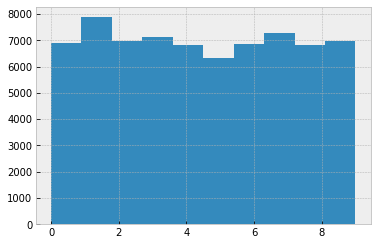

In [2]:
# Finally let's get the dataset

df = pd.read_csv("project/input/mnist.csv")
df.target.hist()

Distribution of classes are pretty even, therefore we can safely sample randomly. Following, we generate our train set with folds and test set.

In [30]:
df_test = df.iloc[60000:,:] # The last 10,000 samples are used in test set.
df_test.to_csv("project/input/mnist_test.csv", index=False)

In [39]:
df_train = df.iloc[:60000,:] # The first 60,000 samples are used in train set.

def create_folds(df, n_splits):
    from sklearn.model_selection import StratifiedKFold
    df["kfold"] = -1
    kStratFold = StratifiedKFold(n_splits=n_splits)

    for fold, (train_, val_) in enumerate(kStratFold.split(X=df, y=df.target.values)):
        df.loc[val_, "kfold"] = fold
    return df

df_folds = create_folds(df_train, 5)


df_folds.to_csv("project/input/mnist_train_folds.csv", index=False)

We have stored our train set with a `kfold` column. What happens when we try to save each fold seperately? Following code demonstrates a `SettingWithCopyWarning` which is easy to overlook and a common perpetrator for causing countless hours of debugging without realizing your processed dataset is not the dataset you are trying to work to begin with.  

In [91]:
fold_index = df_train.kfold.unique() # finding folds

for fold in fold_index:
    index = df_train.kfold == fold
    temp = df_train.loc[index,:]
    temp.drop("kfold", axis=1, inplace=True)
#     temp.to_csv(f"project/input/mnist_fold{fold}.csv", index=False)

/home/onur/miniconda3/envs/ml/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Even though this example is valid and outputs the desired folds, this type of warning is not be ignored. When we are dealing with indexing a dataframe resulting a view instead of new copy, pandas yields unexpected results. Below code shows that `temp` is not a view, but its elements are still references to the original dataframe.

In [92]:
temp._is_view, temp._is_copy

(False, <weakref at 0x7f670b0d2230; to 'DataFrame' at 0x7f670bf26750>)

To solve this, we disregard `inplace` parameter and instead we assign a new `temp` every loop iteration. Below code do not ouptuts a warning.  

In [168]:
fold_index = df_train.kfold.unique() # finding folds

for fold in fold_index:
    index = df_train.kfold == fold
    temp = df_train.loc[index,:]
    print(temp.shape)
    temp = temp.drop("kfold", axis=1) # Instead of inplace, new dataframe every loop iteration
    print(temp.shape)
#     temp.drop("kfold", axis=1, inplace=True) 
#     temp.to_csv(f"project/input/mnist_fold{fold}.csv", index=False)

(12000, 786)
(12000, 785)
(12000, 786)
(12000, 785)
(12000, 786)
(12000, 785)
(12000, 786)
(12000, 785)
(12000, 786)
(12000, 785)
